# Sentiment Classification Using Logistic Regression

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import random
import torch
from util import *

## Sentiment Classification Dataset 

The training data consists of a collection of short hotel reviews. The data is formatted as one review per line. Each line starts with a unique identifier for the review (as in ID-2001) followed by tab and the text of the review.  The reviews are not tokenized or sentence segmented in any way (the words are space separated). The positive reviews and negative reviews appear in separate files namely [hotelPosT-train.txt](data/hotelPosT-train.txt) and [hotelNegT-train.txt](data/hotelNegT-train.txt).

In [3]:
# loading the dataset

def load_train_data(positive_filepath, negative_filepath):
    def _read(filename):
        texts = []
        with open(filename, "r", encoding="utf-8") as f:
            for line in f:
                _id, text = line.rstrip().split("\t")
                texts.append(text)
        return texts

    texts = []
    labels = []

    for text in _read(positive_filepath):
        texts.append(text)
        labels.append(1)

    for text in _read(negative_filepath):
        texts.append(text)
        labels.append(0)

    return texts, labels


pos_datapath = "data/hotelPosT-train.txt"
neg_datapath = "data/hotelNegT-train.txt"
all_texts, all_labels = load_train_data(pos_datapath, neg_datapath)

### Let's look at what is in the data

In [4]:
# printing positive and negative examples from all_texts
def random_sample(texts, labels, label):
    data_by_label = {}
    for lab, text in zip(labels, texts):
        if lab not in data_by_label:
            data_by_label[lab] = []
        data_by_label[lab].append(text)
    return random.choice(data_by_label[label])

print("--- Positive Example ---")
print(random_sample(all_texts, all_labels, label=1))
print("\n--- Negative Example ---")
print(random_sample(all_texts, all_labels, label=0))

--- Positive Example ---
Once you book a room at the Baltimore Hyatt Regency Hotel, you will get an instant feeling of being right at home. The hotel staff greets all of it's customers with warm smiles and candy. The hotel staff, upon request, can give you a tour of the room that you plan to book. Once you are in your hotel room, the rooms are emmaculate. Overlooking the Inner Harbor and all of it's attractions. I was able to visit the attractions, have dinner in the hotel's dining room, and kick back and enjoy the room.

--- Negative Example ---
Upon check in at the hotel the front desk person was very rude, and attenitive in the least. The room was dirty, and the jaccuzi was filthy and out dated.


### Test Data 

In [5]:
# Loading the test data

def load_test_data(filepath):
    texts = []
    labels = []
    label_mapping = {'POS': 1, 'NEG': 0}  
    with open(filepath, "r", encoding="utf-8") as file:
        for line in file:
            idx, text, label = line.rstrip().split("\t")
            texts.append(text)
            labels.append(label_mapping[label])  
    return texts, labels

# Example usage
test_datapath = "data/testset.txt"
test_texts, test_labels = load_test_data(test_datapath)

### Printing the number of "positive" and "negative" samples 

In [6]:
def label_distribution(labels):
    ar = np.array(labels)
    pos_count = np.count_nonzero(ar == 1)
    neg_count = ar.size - pos_count
    print("Size of the List of Labels: ",ar.size)
    print("Number of positive labels(1): ",pos_count)
    print("Number of negative labels(0): ", neg_count)
    """
    TODO: Replace the line `raise NotImplementedError` with your code
    to print the labels distribution.

    Args:
        labels (List[int]): Labels for the dataset. 1 = postive, 0 = negative
    
    Returns
        pos_count, neg_count (int, int): The counts of each label
    """
    return pos_count, neg_count


label_distribution(all_labels)

Size of the List of Labels:  189
Number of positive labels(1):  95
Number of negative labels(0):  94


(95, 94)

### Splitting Training and Development Sets 

For the purpose of coming with the best parameters for the model we will have to split the dataset into training and development sets. Make sure the splits follow the same distribution.

In [7]:
def split_dataset(texts, labels):
    X, y = np.array(texts), np.array(labels)
    n_samples = X.shape[0]
    indices = np.random.permutation(n_samples)
    test_set_size = int(n_samples * 0.2)
    test_indices = indices[:test_set_size]
    train_indices = indices[test_set_size:]
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    """
    Split the dataset randomly into 80% training and 20% development set
    Make sure the splits have the same label distribution
    """
    return X_train, y_train, X_test, y_test

train_texts, train_labels, dev_texts, dev_labels = split_dataset(all_texts, all_labels)

print('Train Label Distribution:')
label_distribution(train_labels)

print('Dev Label Distribution:')
label_distribution(dev_labels)

Train Label Distribution:
Size of the List of Labels:  152
Number of positive labels(1):  80
Number of negative labels(0):  72
Dev Label Distribution:
Size of the List of Labels:  37
Number of positive labels(1):  15
Number of negative labels(0):  22


(15, 22)

### Evaluation Metrics

Implementing the evaulation metrics: Accuracy, Precision, Recall and F1 score

In [8]:
def accuracy(predicted_labels, true_labels):
    correct = sum([1 for true,pred in zip(true_labels,predicted_labels) if true==pred])
    total = len(true_labels)
    """
    Accuracy is correct predictions / all predicitons
    """
    
    return correct/total

def precision(predicted_labels, true_labels):
    true_positive = sum([1 for true, pred in zip(true_labels, predicted_labels) if true == pred == 1])
    false_positive = sum([1 for true, pred in zip(true_labels, predicted_labels) if true == 0 and pred == 1])
    if (true_positive + false_positive) == 0:
        return 0
    """
    Precision is True Positives / All Positives Predictions
    """
    
    return true_positive / (true_positive + false_positive)

def recall(predicted_labels, true_labels):
    true_positive = sum([1 for true, pred in zip(true_labels, predicted_labels) if true == pred == 1])
    false_negative = sum([1 for true, pred in zip(true_labels, predicted_labels) if true == 1 and pred == 0])
    
    if (true_positive + false_negative) == 0:
        return 0
    """
    Recall is True Positives / All Positive Labels
    """
    
    return true_positive / (true_positive + false_negative)

def f1_score(predicted_labels, true_labels):
    prec = precision(true_labels, predicted_labels)
    rec = recall(true_labels, predicted_labels)
    if (prec + rec) == 0:
        return 0
    """
    F1 score is the harmonic mean of precision and recall
    """
    
    return 2 * (prec * rec) / (prec + rec)

In [9]:
em_test_labels = [0]*6 + [1]*4
em_test_predictions = [0]*8 + [1]*2

em_test_accuracy = 0.8
em_test_precision = 1.0
em_test_recall = 0.5
em_test_f1 = 2/3

assert accuracy(em_test_predictions, em_test_labels) == em_test_accuracy
assert precision(em_test_predictions, em_test_labels) == em_test_precision 
assert recall(em_test_predictions, em_test_labels) == em_test_recall
assert f1_score(em_test_predictions, em_test_labels) == em_test_f1

print('All Test Cases Passed!')

All Test Cases Passed!


## Baselines 

It is important to come up with baselines for the classifications to compare the more complicated models with. The baselines are also useful as a debugging method for your actual classfication model. We will create two baselines:

1. Random Chance
2. Naive Bayes Classifier

### 1: Random Chance Classifier

A random chance classifier predicts the label according to the label's distribution. As an example, if the label 1 appears 70% of the times in the training set, you predict 70 out of 100 times the label 1 and label 0 30% of the times

In [10]:
def predict_random(train_labels, num_samples):
    """
    Using the label distribution, predict the label num_sample number of times
    """
    label_count = np.bincount(train_labels)
    
    label_prob = label_count / len(train_labels)
    return np.random.choice([0, 1], size=num_samples, p=label_prob)

In [11]:
rc_labels = np.array([1]*10 + [0]*5, dtype=int)
rc_predictions = predict_random(rc_labels, 3)
assert len(rc_predictions) == 3
assert len(set(rc_predictions).difference({0, 1})) == 0

rc_labels = np.array([0]*10 + [1]*5, dtype=int)
rc_predictions = predict_random(rc_labels, 100)
p, n = label_distribution(rc_predictions)
assert n > p

rc_labels = np.array([1]*10 + [0]*5, dtype=int)
rc_predictions = predict_random(rc_labels, 100)
p, n = label_distribution(rc_predictions)
assert p > n

print('All Test Cases Passed!')

Size of the List of Labels:  100
Number of positive labels(1):  29
Number of negative labels(0):  71
Size of the List of Labels:  100
Number of positive labels(1):  70
Number of negative labels(0):  30
All Test Cases Passed!


### 2: Naive Bayes Classifier 

Here we will implement a Naive Bayes Classifier using the tokens in the training sample. As a preprocessing step, we will tokenize via whitespace separation and lowercase all tokens.

### Preprocessing 

Tokenizing text by separating by whitespace, and then lowercase all tokens.

In [12]:
def preprocess(text):
    if isinstance(text, str):
        # If text is a string, split it into words and convert to lowercase
        return [word.lower() for word in text.split()]
    elif isinstance(text, list):
        # If text is already a list, convert each word to lowercase
        return [word.lower() for word in text]
    
test_string = "This sentence needs to be preprocessed."

assert preprocess(test_string) == ['this', 'sentence', 'needs', 'to', 'be', 'preprocessed.']

print('All Test Cases Passed!')

All Test Cases Passed!


### The Naive Bayes Class 

The standard way for implementing classifiers like Naive Bayes is to implement the two methods: "fit" and "predict". 

The fit method expects the training data along with labels, and the predict method predicts the labels for the provides texts of samples.

In [13]:
class NaiveBayesClassifier:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.label_word_counter = [{} for _ in range(num_classes)]
        self.label_words_count = [0] * num_classes
        self.vocab = set()
    
    def fit(self, texts, labels): 
        """
        1. Group samples by their labels
        2. Preprocess each text
        3. Count the words of the text for each label
        """
        for text, label in zip(texts, labels):
            self.label_words_count[label] += 1
            words = preprocess(text)
            self.vocab.update(words)
            
            for word in words:
                if word not in self.label_word_counter[label]:
                    self.label_word_counter[label][word] = 0
                self.label_word_counter[label][word] += 1 
                self.label_words_count[label] += 1
    
    def predict(self, texts):
        """
        1. Preprocess the texts
        2. Predict the class by using the likelihood with Bayes Method and Laplace Smoothing
        """
        predictions = []
        vocab_size = len(self.vocab)
        
        for text in texts:
            words = preprocess(text)
            log_probs = [0] * self.num_classes

            total_samples = sum(self.label_words_count)  
            
            for label in range(self.num_classes):
                log_probs[label] = np.log(self.label_words_count[label] / total_samples)

                
                for word in words:
                    word_count = self.label_word_counter[label].get(word, 0) + 1  
                    total_words = self.label_words_count[label] + vocab_size  
                    log_probs[label] += np.log(word_count / total_words)  
            
            
            predicted_label = np.argmax(log_probs)
            predictions.append(predicted_label)
        
        return predictions

        

### Baseline Results

Since there is not hyperparameter-tuing required for the baselines, we can use the entirety of the training set (no need to split the dataset into train and development). Reporting the results achieved with the two baselines.

In [14]:
### DEV SET RESULTS

testset_prediction_random = predict_random(train_labels, num_samples=len(dev_labels))
print('Random Chance F1:', f1_score(testset_prediction_random, dev_labels))

naive_bayes_classifier = NaiveBayesClassifier(num_classes=2)
naive_bayes_classifier.fit(train_texts, train_labels)
testset_predictions_nb = naive_bayes_classifier.predict(dev_texts)
print('Naive Bayes F1:', f1_score(testset_predictions_nb, dev_labels))

Random Chance F1: 0.47058823529411764
Naive Bayes F1: 0.9375


In [15]:
### TEST SET RESULTS

testset_prediction_random = predict_random(all_labels, num_samples=len(test_labels))
print('Random Chance F1:', f1_score(testset_prediction_random, test_labels))

naive_bayes_classifier = NaiveBayesClassifier(num_classes=2)
naive_bayes_classifier.fit(all_texts, all_labels)
testset_predictions_nb = naive_bayes_classifier.predict(test_texts)
print('Naive Bayes F1:', f1_score(testset_predictions_nb, test_labels))

Random Chance F1: 0.4897959183673469
Naive Bayes F1: 0.8627450980392156


## Logistic Regression on Features 

Now we will be building a logistic regression based classifier on hand-engineered features.

There will be implementation of the components that are required in building a Logistic Regressor.

### Feature Extraction 

In [16]:
from collections import defaultdict
final_feature_dict = defaultdict

def count_words(text):
    return np.log(len(text))

def has_exclamation(text):
    for word in text:
        if '!' in word:
            return 1
    return 0

def count_positive_words(text):
    count = 0
    pos_file =  open('data/positive-words.txt')
    words  = pos_file.readlines()
    ref_word = [word.replace('\n','') for word in words]
    for word in text:
        if word in ref_word:
            count = count + 1    
    return count

def count_negative_words(text):
    count = 0
    neg_file = open('data/negative-words.txt')
    words  = neg_file.readlines()
    ref_word = [word.replace('\n','') for word in words]
    for word in text:
        if word in ref_word:
            count = count + 1    
    return count

def count_pronoun(text):
    count = 0
    first_pronoun = ['i', 'me' , 'my' , 'mine', 'we', 'our', 'us', 'myself', 'ourselves']
    second_pronoun = ['you', 'your', 'yours', 'yourself', 'yourselves']
    tot =  first_pronoun + second_pronoun
    for word in text:
        if word in tot:
            count = count + 1
    return count

def extract_features(text):
    features = []
    
    features.append(count_words(text))  # Number of words
    features.append(has_exclamation(text))  # Presence of exclamation marks
    features.append(count_positive_words(text))  # Count of positive words
    features.append(count_negative_words(text))  # Count of negative words
    features.append(count_pronoun(text))
    
    
    return features

In [17]:
### DO NOT CHANGE THE SIGNATURE OF THE function ###

def featurize_data(texts, labels):
    features = [
        extract_features(preprocess(text)) for text in texts
    ]
    return torch.FloatTensor(features), torch.FloatTensor(labels)

### Feature Scaling 

Here we are using data normalization technique to ensure the scales of the feature are consistent.
After featurizing the dataset, we will be calling the following function before passing it to the classifier

#### Normalization Formula

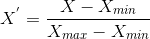

In [18]:
def normalize(features: torch.Tensor) -> torch.Tensor:
    """
    return the features transformed by the above formula of normalization
    """
    min_vals = torch.min(features, dim=0, keepdim=True).values
    max_vals = torch.max(features, dim=0, keepdim=True).values
    normalized_features = (features - min_vals) / (max_vals - min_vals)
    return normalized_features

## Training a Logistic Regression Classifier

Here we will be implementing the components needed to train the binary classifier using logistic regression.

### Here we define our pytorch logistic regression classifier 

In [19]:
class SentimentClassifier(torch.nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        
        self.output_size = 1
        self.coefficients = torch.nn.Linear(input_dim, self.output_size)
        
        initialize_weights(self.coefficients)
        
    def forward(self, features: torch.Tensor):
        
        return torch.sigmoid(self.coefficients(features))

### Initializing the weights. 

Initialization of the parameters is an important step to ensure the SGD algorithm converges to a global optimum. Typically, we will try different initialization methods and compare the accuracy we achieve for the development set. 

In [20]:
def initialize_weights(coefficients):
    """
    TODO: Replace the line `raise NotImplementedError` with your code.
    Initialize the weights of the coefficients by assigning the parameter
    coefficients.weights.data = ...
    """
    coefficients.weight.data.fill_(1.0)

In [21]:
test_module = torch.nn.Linear(5, 1)
initialize_weights(test_module)
assert test_module.weight.ravel().tolist() == [1.0, 1.0, 1.0, 1.0, 1.0]

print('All Test Cases Passed!')

All Test Cases Passed!


We will be writing the loss function by implementing binary cross-entropy loss between the prediction and label. The binary cross-entropy loss between the prediction y_hat and the target y, averaged over N examples, is:


### Logistic Loss Function 

In [22]:
def logistic_loss(prediction: torch.Tensor, label: torch.Tensor) -> torch.Tensor:
    """
    TODO: Implement the logistic loss function between a prediction and label.
    """
    epsilon = 1e-10
    prediction = torch.clamp(prediction, epsilon, 1 - epsilon)
    
    # Binary cross-entropy loss
    loss = - (label * torch.log(prediction) + (1 - label) * torch.log(1 - prediction))

    loss = torch.where(prediction == label, torch.tensor(0.0), loss)
    
    # Return the average loss over all samples
    return loss.mean()

In [23]:
# Sanity check
sample_input = torch.FloatTensor([[1,1],[0.0,0.0]])
sample_target = torch.FloatTensor([[1,1],[0,0]])
sample_output = logistic_loss(sample_input, sample_target)
print(sample_output)
assert sample_output.item() == 0.0

tensor(0.)


### Creating an SGD optimizer

here we will be creating the SGD optimizer.

In [24]:
def make_optimizer(model, learning_rate) -> torch.optim:
    """
    Returns an Stocastic Gradient Descent Optimizer
    """
    return torch.optim.SGD(model.parameters(), learning_rate)

### Converting Logits into Predictions 

In [25]:
def predict(model, features):
    with torch.no_grad():
        """
        TODO: Replace the line `raise NotImplementedError`
        with the logic of converting the logits into prediction labels (0, 1)
        """
        logits = model(features)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).float()  
        return preds

### Training Function 

In [26]:
from tqdm.autonotebook import tqdm
import random


def training_loop(
    num_epochs,
    batch_size,
    train_features,
    train_labels,
    dev_features,
    dev_labels,
    optimizer,
    model
):
    samples = list(zip(train_features, train_labels))
    random.shuffle(samples)
    batches = []
    for i in range(0, len(samples), batch_size):
        batches.append(samples[i:i+batch_size])
    print("Training...")
    for i in range(num_epochs):
        losses = []
        for batch in tqdm(batches):
            # Empty the dynamic computation graph
            features, labels = zip(*batch)
            features = torch.stack(features)
            labels = torch.stack(labels)
            optimizer.zero_grad()
            # Run the model
            logits = model(features)
            # Compute loss
            loss = logistic_loss(torch.squeeze(logits), labels)
            # In this logistic regression example,
            # this entails computing a single gradient
            loss.backward()
            # Backpropogate the loss through our model
            
            # Update our coefficients in the direction of the gradient.
            optimizer.step()
             # For logging
            losses.append(loss.item())
        
        # Estimate the f1 score for the development set
        dev_f1 = f1_score(predict(model, dev_features), dev_labels)
        print(f"epoch {i}, loss: {sum(losses)/len(losses)}")
        print(f"Dev F1 {dev_f1}")
        
    # Return the trained model
    return model

C:\Users\purva31\AppData\Local\Temp\ipykernel_7232\3005717344.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Train the classifier 

Here we are training a logistic regressor on your hand-engineered features.

In [27]:
num_epochs = 100

train_features, train_labels_tensor = featurize_data(train_texts, train_labels)
train_features = normalize(train_features)
dev_features, dev_labels_tensor = featurize_data(dev_texts, dev_labels)
dev_features = normalize(dev_features)
model = SentimentClassifier(train_features.shape[1]) 
optimizer = make_optimizer(model, learning_rate=0.01)

trained_model = training_loop(
    num_epochs,
    16,
    train_features,
    train_labels_tensor,
    dev_features,
    dev_labels_tensor,
    optimizer,
    model
)

Training...


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 0, loss: 0.9311507046222687
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 1, loss: 0.9196842432022094
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 2, loss: 0.9086977541446686
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 3, loss: 0.8981788575649261
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 4, loss: 0.888114583492279
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 5, loss: 0.8784917175769806
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 6, loss: 0.8692965090274811
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 7, loss: 0.8605150282382965
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 8, loss: 0.8521331310272217
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 9, loss: 0.8441366493701935
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 10, loss: 0.8365112245082855
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 11, loss: 0.8292425036430359
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 12, loss: 0.8223163902759552
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 13, loss: 0.8157185673713684
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 14, loss: 0.8094351828098297
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 15, loss: 0.8034524500370026
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 16, loss: 0.7977568566799164
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 17, loss: 0.7923351407051087
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 18, loss: 0.7871743142604828
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 19, loss: 0.7822618365287781
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 20, loss: 0.7775854349136353
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 21, loss: 0.7731332361698151
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 22, loss: 0.7688938081264496
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 23, loss: 0.7648559987545014
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 24, loss: 0.7610092163085938
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 25, loss: 0.7573431193828583
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 26, loss: 0.7538479268550873
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 27, loss: 0.7505141735076905
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 28, loss: 0.7473328649997711
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 29, loss: 0.7442953526973725
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 30, loss: 0.7413934767246246
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 31, loss: 0.7386193871498108
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 32, loss: 0.7359656512737274
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 33, loss: 0.7334252178668976
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 34, loss: 0.7309913992881775
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 35, loss: 0.7286577999591828
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 36, loss: 0.7264184594154358
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 37, loss: 0.7242676436901092
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 38, loss: 0.7222001075744628
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 39, loss: 0.7202106237411499
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 40, loss: 0.7182945430278778
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 41, loss: 0.7164472997188568
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 42, loss: 0.7146647036075592
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 43, loss: 0.7129427134990692
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 44, loss: 0.7112775981426239
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 45, loss: 0.7096659004688263
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 46, loss: 0.7081041812896729
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 47, loss: 0.7065894544124603
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 48, loss: 0.7051187753677368
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 49, loss: 0.7036894142627717
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 50, loss: 0.7022987902164459
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 51, loss: 0.7009445250034332
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 52, loss: 0.6996244192123413
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 53, loss: 0.6983363270759583
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 54, loss: 0.6970782697200775
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 55, loss: 0.6958484590053559
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 56, loss: 0.6946451842784882
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 57, loss: 0.6934667646884918
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 58, loss: 0.692311805486679
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 59, loss: 0.6911788940429687
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 60, loss: 0.690066659450531
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 61, loss: 0.6889739215373993
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 62, loss: 0.6878995299339294
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 63, loss: 0.6868424832820892
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 64, loss: 0.6858016788959503
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 65, loss: 0.6847763180732727
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 66, loss: 0.6837655007839203
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 67, loss: 0.6827683448791504
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 68, loss: 0.6817842066287995
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 69, loss: 0.6808123409748077
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 70, loss: 0.6798521101474762
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 71, loss: 0.6789029121398926
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 72, loss: 0.6779641568660736
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 73, loss: 0.6770353257656098
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 74, loss: 0.6761159598827362
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 75, loss: 0.6752055943012237
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 76, loss: 0.6743037939071655
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 77, loss: 0.673410153388977
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 78, loss: 0.6725243210792542
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 79, loss: 0.671645975112915
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 80, loss: 0.6707746922969818
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 81, loss: 0.6699102878570556
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 82, loss: 0.6690524399280549
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 83, loss: 0.6682008922100067
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 84, loss: 0.6673553884029388
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 85, loss: 0.666515725851059
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 86, loss: 0.665681678056717
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 87, loss: 0.6648530721664428
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 88, loss: 0.6640296876430511
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 89, loss: 0.6632113873958587
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 90, loss: 0.662397974729538
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 91, loss: 0.661589378118515
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 92, loss: 0.6607853412628174
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 93, loss: 0.6599858224391937
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 94, loss: 0.6591906726360321
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 95, loss: 0.6583997547626496
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 96, loss: 0.6576130330562592
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 97, loss: 0.6568303167819977
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 98, loss: 0.6560515999794007
Dev F1 0.5769230769230769


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 99, loss: 0.6552767038345337
Dev F1 0.5769230769230769


### Getting the predictions on the Test Set using the Trained model and printing the F1 score

In [28]:
### DEV SET RESULTS

train_texts, train_labels, dev_texts, dev_labels = split_dataset(all_texts, all_labels)

devset_prediction_random = predict_random(train_labels, num_samples=len(dev_labels))
dev_random_f1 = f1_score(devset_prediction_random, dev_labels)
print('Random Chance F1:', dev_random_f1)

assert dev_random_f1 > 0

print('All Test Cases Passed!')

Random Chance F1: 0.6111111111111113
All Test Cases Passed!


In [29]:
### DEV SET RESULTS - LOGISTIC REGRESSION

dev_features, dev_labels = featurize_data(dev_texts, dev_labels)
dev_features = normalize(dev_features)
dev_logistic_accuracy = accuracy(predict(trained_model, dev_features), dev_labels.tolist())
dev_logistic_f1 = f1_score(predict(trained_model, dev_features), dev_labels.tolist())
print('Logistic Regression Results:')
print('Accuracy:', dev_logistic_accuracy)
print('F1-score', dev_logistic_f1)

Logistic Regression Results:
Accuracy: 0.5135135135135135
F1-score 0.6785714285714285


In [30]:
### TEST SET RESULTS - RANDOM CHANCE

# load the test data
test_datapath = "data/testset.txt"
test_texts, test_labels = load_test_data(test_datapath)

testset_prediction_random = predict_random(all_labels, num_samples=len(test_labels))
test_random_f1 = f1_score(testset_prediction_random, test_labels)
print('Random Chance F1:', test_random_f1)
testset_prediction_naive = naive_bayes_classifier.predict(test_texts)
test_naive_f1 = f1_score(testset_prediction_naive, test_labels)
print('Naive Bayes F1:', test_naive_f1)

Random Chance F1: 0.4615384615384615
Naive Bayes F1: 0.8627450980392156


In [31]:
### TEST SET RESULTS

# load the test data
test_datapath = "data/testset.txt"
test_texts, test_labels = load_test_data(test_datapath)

test_features, test_labels = featurize_data(test_texts, test_labels)
test_features = normalize(test_features)
test_logistic_accuracy = accuracy(predict(trained_model, test_features), test_labels.tolist())
test_logistic_f1 = f1_score(predict(trained_model, test_features), test_labels.tolist())
print('Logistic Regression Results:')
print('Accuracy:', test_logistic_accuracy)
print('F1-score', test_logistic_f1)

Logistic Regression Results:
Accuracy: 0.5
F1-score 0.6666666666666666
